In [41]:
from uwg import UWG

# UWG can only generate 31 days at a time, so this code copies the first month worth of data from the
# epw file provided by onebuilding and creates a new epw file with that data

def filter_epw_file(original_file, new_file):
    with open(original_file, 'r') as infile:
        lines = infile.readlines()

    header = lines[:8]  # preserve the header
    data_lines = lines[8:]  # rest are data

    # format of each line is (Year, Month, Day, Hour, Minute, ...)
    # we assume that the data is ordered chronologically, so we can just find the start of the second month
    for i, line in enumerate(data_lines):
        parts = line.split(',')
        if int(parts[1]) > 1:  # Month value is greater than 1
            break

    # new file consists of header and data for the first month
    new_lines = header + data_lines[:i]

    with open(new_file, 'w') as outfile:
        outfile.writelines(new_lines)

# usage
filter_epw_file(r"D:\uwg-master\resources\Badgerys Creek 2007-2021.epw", r"D:\uwg-master\resources\Badgerys Creek 2007-2021_Jan2010.epw")


In [42]:
# Add inputs

# Input 1 - Blue Graph

model_inputs1 = [
    {'bldheight': 3, 'blddensity': 0.05, 'vertohor': 0.2, 'grasscover': 0.7, 'treecover': 0.2, 'zone': '2A',
     'charlength': 1080, 'h_mix': 0.1, 'albroad': 0.5}
]

# Input 2 - Orange Graph

model_inputs2 = [
    {'bldheight': 50, 'blddensity': 0.9, 'vertohor': 0.9, 'grasscover': 0.05, 'treecover': 0.04, 'zone': '2A',
    'charlength': 1080, 'h_mix': 0.8, 'albroad': 0.1}
]

# charlength = length of area (one side of square) in m. Badgerys Creek covers an area of about 27km2
# h_mix = HVAC waste heat released into street canyon.
# albroad = albedo of roads
# zone = ASHRAE weather zone of area. Badgerys Creek is Zone 2A (Temperate)

Simulating new temperature and humidity values for 31 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
New climate file is generated at D:\uwg-master\resources\Badgerys Creek 2007-2021_Jan2010_UWG.epw.


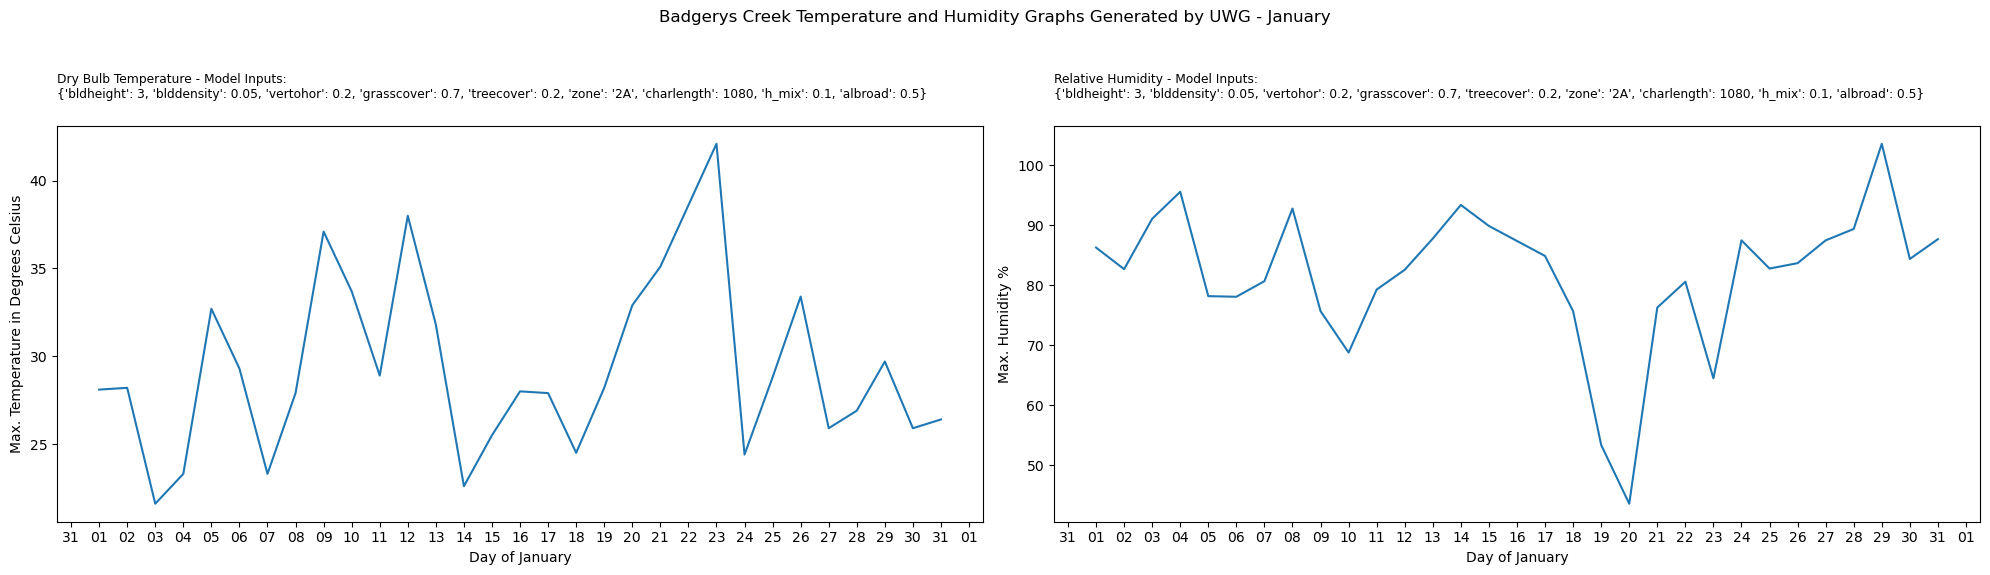

In [43]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def daily_max(df1, variable):
    return df1.groupby(df1['Date'])[variable].max()

def read_epw(epw_file):
    with open(epw_file, 'r') as f:
        lines = f.readlines()

    # Process header lines
    header_lines = lines[:8]
    location_info = header_lines[0].split(',')
    latitude, longitude = float(location_info[6]), float(location_info[7])

    # Process data lines
    data_lines = lines[8:]
    data = [line.split(',') for line in data_lines]

    # Create a DataFrame from the data
    df1 = pd.DataFrame(data, columns=columns)

    # Convert columns to numeric types
    df1[numeric_columns] = df1[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Make sure 'Year', 'Month' and 'Day' are integer
    df1[['Year', 'Month', 'Day']] = df1[['Year', 'Month', 'Day']].astype(int)
    
    # Combine 'Year', 'Month', and 'Day' into a new 'Date' column
    df1['Date'] = pd.to_datetime(df1[['Year', 'Month', 'Day']])
    
    return df1

columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Data Source and Uncertainty Flags',
           'Dry Bulb Temperature', 'Dew Point Temperature', 'Relative Humidity',
           'Atmospheric Station Pressure', 'Extraterrestrial Horizontal Radiation',
           'Extraterrestrial Direct Normal Radiation', 'Horizontal Infrared Radiation Intensity',
           'Global Horizontal Radiation', 'Direct Normal Radiation', 'Diffuse Horizontal Radiation',
           'Global Horizontal Illuminance', 'Direct Normal Illuminance', 'Diffuse Horizontal Illuminance',
           'Zenith Luminance', 'Wind Direction', 'Wind Speed', 'Total Sky Cover',
           'Opaque Sky Cover', 'Visibility', 'Ceiling Height', 'Present Weather Observation',
           'Present Weather Codes', 'Precipitable Water', 'Aerosol Optical Depth', 'Snow Depth',
           'Days Since Last Snowfall', 'Albedo', 'Liquid Precipitation Depth',
           'Liquid Precipitation Quantity', 'Liquid Precipitation Hours']

numeric_columns = [col for col in columns if col != 'Data Source and Uncertainty Flags']

epw_path = r"D:\uwg-master\resources\Badgerys Creek 2007-2021_Jan2010.epw"

fig, axes = plt.subplots(nrows=len(model_inputs1), ncols=2, figsize=(20, 6 * len(model_inputs1)))
fig.suptitle('Badgerys Creek Temperature and Humidity Graphs Generated by UWG - January')

for i, inputs in enumerate(model_inputs1):
    model = UWG.from_param_args(epw_path=epw_path, **inputs)
    model.generate()
    model.simulate()
    model.write_epw()

    inputs_str = '_'.join(f"{k}={v}" for k, v in inputs.items())
    inputs_str = inputs_str.replace('.', 'p')

    timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
    output_filename2 = f"Badgerys Creek 2007-2021_UWG_{inputs_str}_{timestamp}.epw"
    output_path2 = r"D:\uwg-master\resources\\" + output_filename2

    original_file_path = r"D:\uwg-master\resources\Badgerys Creek 2007-2021_Jan2010_UWG.epw"

    os.rename(original_file_path, output_path2)

    epw_file = output_path2

    df1 = read_epw(epw_file)

variables = ['Dry Bulb Temperature', 'Relative Humidity']

for idx, variable in enumerate(variables):
    ax = axes[idx] if len(model_inputs1) == 1 else axes[i][idx]

    daily_max_profile = daily_max(df1, variable)

    ax.plot(daily_max_profile.index.day - 1, daily_max_profile.values)  # Change x values to just the day of the month
    ax.xaxis.set_major_locator(mdates.DayLocator())  # Ensure we mark every day on the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Format x-axis labels to only show the day of the month
    ax.set_xlabel('Day of January')
    ax.set_ylabel('Max. Temperature in Degrees Celsius' if variable == 'Dry Bulb Temperature' else 'Max. Humidity %')
    ax.set_title(f"{variable} - Model Inputs:\n{inputs}", loc='left', pad=20, fontsize=8.8)

    # Adjust subplot spacing
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(hspace=0.5)
plt.show()


Simulating new temperature and humidity values for 31 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
New climate file is generated at D:\uwg-master\resources\Badgerys Creek 2007-2021_Jan2010_UWG.epw.


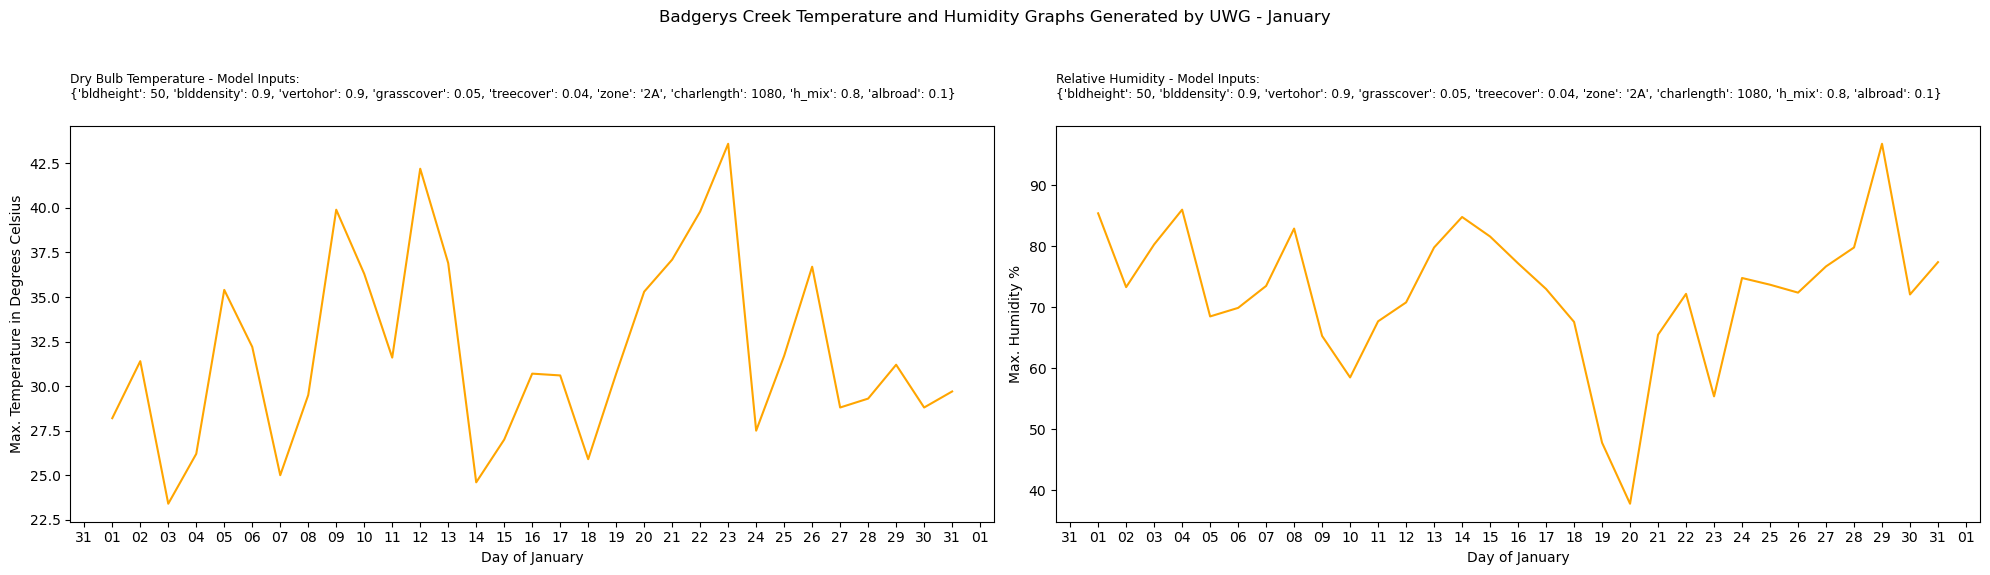

In [44]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from uwg import UWG
import matplotlib.dates as mdates

def daily_max(df2, variable):
    return df2.groupby(df2['Date'])[variable].max()

def read_epw(epw_file):
    with open(epw_file, 'r') as f:
        lines = f.readlines()

    # Process header lines
    header_lines = lines[:8]
    location_info = header_lines[0].split(',')
    latitude, longitude = float(location_info[6]), float(location_info[7])

    # Process data lines
    data_lines = lines[8:]
    data = [line.split(',') for line in data_lines]

    # Create a DataFrame from the data
    df2 = pd.DataFrame(data, columns=columns)

    # Convert columns to numeric types
    df2[numeric_columns] = df2[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Make sure 'Year', 'Month' and 'Day' are integer
    df2[['Year', 'Month', 'Day']] = df2[['Year', 'Month', 'Day']].astype(int)
    
    # Combine 'Year', 'Month', and 'Day' into a new 'Date' column
    df2['Date'] = pd.to_datetime(df2[['Year', 'Month', 'Day']])
    
    return df2

columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Data Source and Uncertainty Flags',
           'Dry Bulb Temperature', 'Dew Point Temperature', 'Relative Humidity',
           'Atmospheric Station Pressure', 'Extraterrestrial Horizontal Radiation',
           'Extraterrestrial Direct Normal Radiation', 'Horizontal Infrared Radiation Intensity',
           'Global Horizontal Radiation', 'Direct Normal Radiation', 'Diffuse Horizontal Radiation',
           'Global Horizontal Illuminance', 'Direct Normal Illuminance', 'Diffuse Horizontal Illuminance',
           'Zenith Luminance', 'Wind Direction', 'Wind Speed', 'Total Sky Cover',
           'Opaque Sky Cover', 'Visibility', 'Ceiling Height', 'Present Weather Observation',
           'Present Weather Codes', 'Precipitable Water', 'Aerosol Optical Depth', 'Snow Depth',
           'Days Since Last Snowfall', 'Albedo', 'Liquid Precipitation Depth',
           'Liquid Precipitation Quantity', 'Liquid Precipitation Hours']

numeric_columns = [col for col in columns if col != 'Data Source and Uncertainty Flags']

epw_path = r"D:\uwg-master\resources\Badgerys Creek 2007-2021_Jan2010.epw"

fig, axes = plt.subplots(nrows=len(model_inputs2), ncols=2, figsize=(20, 6 * len(model_inputs2)))
fig.suptitle('Badgerys Creek Temperature and Humidity Graphs Generated by UWG - January')

for i, inputs in enumerate(model_inputs2):
    model = UWG.from_param_args(epw_path=epw_path, **inputs)
    model.generate()
    model.simulate()
    model.write_epw()

    inputs_str = '_'.join(f"{k}={v}" for k, v in inputs.items())
    inputs_str = inputs_str.replace('.', 'p')

    timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
    output_filename2 = f"Badgerys Creek 2007-2021_UWG_{inputs_str}_{timestamp}.epw"
    output_path2 = r"D:\uwg-master\resources\\" + output_filename2

    original_file_path = r"D:\uwg-master\resources\Badgerys Creek 2007-2021_Jan2010_UWG.epw"

    os.rename(original_file_path, output_path2)

    epw_file = output_path2

    df2 = read_epw(epw_file)

variables = ['Dry Bulb Temperature', 'Relative Humidity']

for idx, variable in enumerate(variables):
    ax = axes[idx] if len(model_inputs2) == 1 else axes[i][idx]

    daily_max_profile = daily_max(df2, variable)

    ax.plot(daily_max_profile.index.day - 1, daily_max_profile.values, color='orange')  # Add 1 to x values to start from 1st day
    ax.xaxis.set_major_locator(mdates.DayLocator())  # Ensure we mark every day on the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Format x-axis labels to only show the day of the month
    ax.set_xlabel('Day of January')
    ax.set_ylabel('Max. Temperature in Degrees Celsius' if variable == 'Dry Bulb Temperature' else 'Max. Humidity %')
    ax.set_title(f"{variable} - Model Inputs:\n{inputs}", loc='left', pad=20, fontsize=8.8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


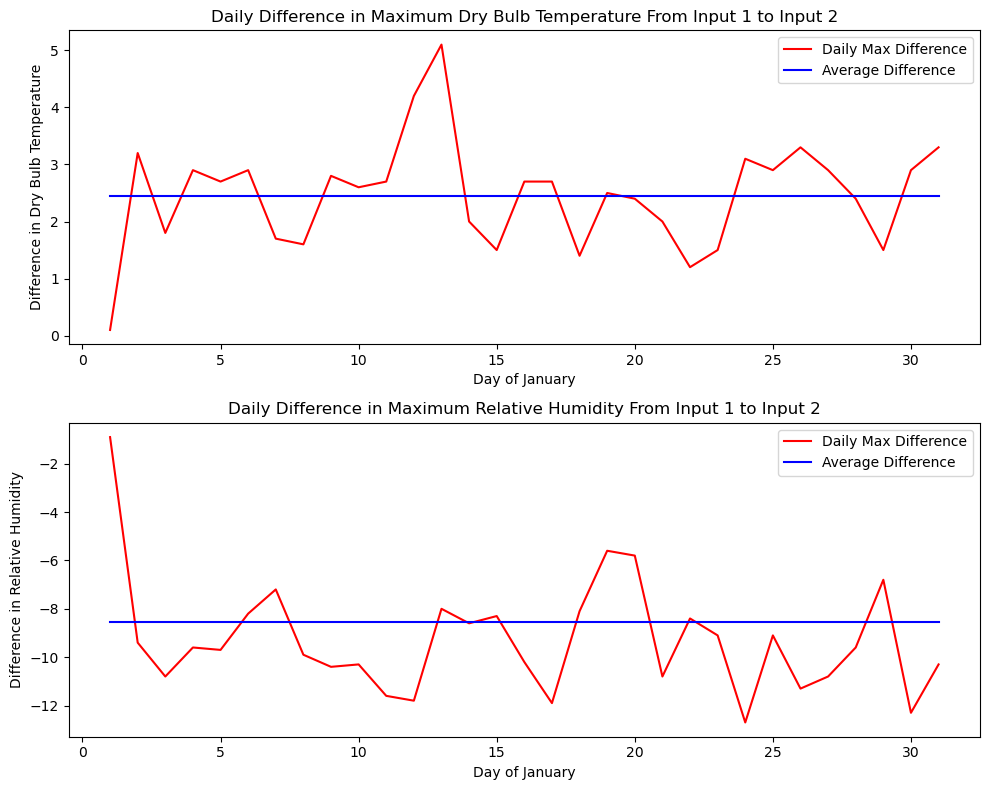

In [45]:
variables = ['Dry Bulb Temperature', 'Relative Humidity']
max_values1 = {var: daily_max(df1, var) for var in variables}
max_values2 = {var: daily_max(df2, var) for var in variables}

# Compute the averages for each variable in each dataframe
avg_values1 = {var: df1[var].mean() for var in variables}
avg_values2 = {var: df2[var].mean() for var in variables}

# Create a new dataframe for the differences
diff_df = pd.DataFrame({var: max_values2[var] - max_values1[var] for var in variables})

# Create a new dataframe for the averages
avg_df = pd.DataFrame({var: [avg_values2[var] - avg_values1[var]]*len(df1) for var in variables}, index=df1['Date'])

# Plot the differences
fig, axes = plt.subplots(nrows=2, figsize=(10, 8))

for idx, var in enumerate(variables):
    ax = axes[idx]
    ax.plot(diff_df.index.day, diff_df[var].values, color='red', label='Daily Max Difference')
    ax.plot(avg_df.index.day, avg_df[var].values, color='blue', label='Average Difference')
    ax.set_xlabel('Day of January')
    ax.set_ylabel(f'Difference in {var}')
    ax.set_title(f'Daily Difference in Maximum {var} From Input 1 to Input 2')
    ax.legend()

fig.tight_layout()
plt.show()
